In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson

In [2]:
import seaborn as sns

In [3]:
df_dat = pd.read_csv('dat_on.csv')
df_nha = pd.read_csv('nha_on.csv')
df_canho = pd.read_csv('canho_on.csv')

In [4]:
df_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 73 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1322 non-null   int64  
 1   kieu                     1322 non-null   object 
 2   tong_quan                1322 non-null   object 
 3   phap_ly_chuan            1322 non-null   object 
 4   phuong                   1322 non-null   object 
 5   log_gia_tong_ty          1322 non-null   float64
 6   log_dien_tich_m2         1322 non-null   float64
 7   log_gia_m2_trieu         1322 non-null   float64
 8   log_chieu_rong_m         1322 non-null   float64
 9   log_hem_width_m          1322 non-null   float64
 10  log_so_tien_ich_khu_vuc  1322 non-null   float64
 11  kieu_encoded             1322 non-null   float64
 12  phap_ly_encoded          1322 non-null   float64
 13  quan_encoded             1322 non-null   int64  
 14  huong_chuan_encoded     

In [5]:
df_nha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5320 non-null   int64  
 1   so_tien_ich_noi_khu  5320 non-null   float64
 2   so_tien_ich_khu_vuc  5320 non-null   float64
 3   log_gia_tong_ty      5320 non-null   float64
 4   log_dien_tich_m2     5320 non-null   float64
 5   log_phong_ngu_int    5320 non-null   float64
 6   log_gia_m2_trieu     5320 non-null   float64
 7   log_chieu_rong_m     5320 non-null   float64
 8   log_phantram_tang    5320 non-null   float64
 9   log_phong_tam_int    5320 non-null   float64
 10  log_so_tang_int      5320 non-null   float64
 11  log_hem_width_m      5320 non-null   float64
 12  log_chieu_dai_m      5320 non-null   float64
 13  kieu_encoded         5320 non-null   float64
 14  phap_ly_encoded      5320 non-null   float64
 15  noi_that_encoded     5320 non-null   f

In [6]:
df_canho.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7608 entries, 0 to 7607
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           7608 non-null   int64  
 1   so_tien_ich_khu_vuc  7608 non-null   float64
 2   log_gia_tong_ty      7608 non-null   float64
 3   log_dien_tich_m2     7608 non-null   float64
 4   log_phong_ngu_int    7608 non-null   float64
 5   log_gia_m2_trieu     7608 non-null   float64
 6   log_phong_tam_int    7608 non-null   float64
 7   kieu_encoded         7608 non-null   float64
 8   noi_that_encoded     7608 non-null   float64
 9   quan_encoded         7608 non-null   int64  
 10  hcm                  7608 non-null   float64
 11  hn                   7608 non-null   float64
 12  quan_binh_chanh      7608 non-null   float64
 13  quan_binh_thanh      7608 non-null   float64
 14  quan_binh_tan        7608 non-null   float64
 15  quan_bac_tu_liem     7608 non-null   f

In [61]:
def split_train_test_dev(df: pd.DataFrame):
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
    # Chia temp thành dev và test
    dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    print(f"Train: {train_df.shape}, Dev: {dev_df.shape}, Test: {test_df.shape}")
    return train_df, dev_df, test_df

In [62]:
def split_X_y(df: pd.DataFrame, target_col: str):
    cols = [col for col in df.columns.tolist() if col != target_col]
    X = df[cols]
    y = df[target_col]
    return X, y

In [63]:
def scalerZscore(X: pd.DataFrame, cols_to_scale: list[str], name_dataset: str, scaler_dict: dict = None):
    """
    Chuẩn hóa z-score cho các cột được chọn.
    Args:
        X: DataFrame đầu vào.
        cols_to_scale: Danh sách tên cột cần chuẩn hóa.
        name_dataset: 'train' hoặc 'test'.
        scaler_dict: Dict lưu các StandardScaler theo cột.
    Returns:
        X_scaled: DataFrame đã chuẩn hóa (vẫn giữ các cột không chuẩn hóa).
        scaler_dict: dict các scaler cho từng cột (chỉ cập nhật khi 'train').
    """
    if scaler_dict is None:
        scaler_dict = {}

    X_scaled = X.copy()

    for col in cols_to_scale:
        if name_dataset == 'train':
            scaler = StandardScaler()
            X_scaled[col] = scaler.fit_transform(X[[col]])
            scaler_dict[col] = scaler
        else:
            scaler = scaler_dict.get(col)
            if scaler is not None:
                X_scaled[col] = scaler.transform(X[[col]])
            else:
                raise ValueError(f"Scaler for column '{col}' not found in scaler_dict.")

    return X_scaled, scaler_dict

In [64]:
def scalerMinMax(X: pd.DataFrame, cols_to_scale: list[str], name_dataset: str, scaler_dict: dict = None):
    """
    Scale MinMax các cột được chọn.

    Args:
        X: DataFrame đầu vào.
        cols_to_scale: Danh sách tên cột cần scale.
        name_dataset: 'train' hoặc 'test'.
        scaler_dict: Dict lưu MinMaxScaler cho từng cột.

    Returns:
        X_scaled: DataFrame đã scale.
        scaler_dict: dict chứa scaler ứng với mỗi cột.
    """
    if scaler_dict is None:
        scaler_dict = {}

    X_scaled = X.copy()

    for col in cols_to_scale:
        if name_dataset == 'train':
            scaler = MinMaxScaler()
            X_scaled[col] = scaler.fit_transform(X[[col]])
            scaler_dict[col] = scaler
        else:
            scaler = scaler_dict.get(col)
            if scaler is not None:
                X_scaled[col] = scaler.transform(X[[col]])
            else:
                raise ValueError(f"Scaler for column '{col}' not found in scaler_dict.")

    return X_scaled, scaler_dict

In [65]:
df_dat.drop(columns=['kieu','tong_quan','phap_ly_chuan','phuong'],inplace=True)

In [66]:
train_dat_df, dev_dat_df, test_dat_df = split_train_test_dev(df_dat)
train_nha_df, dev_nha_df, test_nha_df = split_train_test_dev(df_nha)
train_ch_df, dev_ch_df, test_ch_df = split_train_test_dev(df_canho)

Train: (925, 69), Dev: (198, 69), Test: (199, 69)
Train: (3724, 80), Dev: (798, 80), Test: (798, 80)
Train: (5325, 60), Dev: (1141, 60), Test: (1142, 60)


In [67]:
X_train_dat, y_train_dat = split_X_y(train_dat_df,'log_gia_tong_ty')
X_dev_dat, y_dev_dat = split_X_y(dev_dat_df,'log_gia_tong_ty')
X_test_dat, y_test_dat = split_X_y(test_dat_df,'log_gia_tong_ty')

X_train_nha, y_train_nha = split_X_y(train_nha_df,'log_gia_tong_ty')
X_dev_nha, y_dev_nha = split_X_y(dev_nha_df,'log_gia_tong_ty')
X_test_nha, y_test_nha = split_X_y(test_nha_df,'log_gia_tong_ty')

X_train_ch, y_train_ch = split_X_y(train_ch_df,'log_gia_tong_ty')
X_dev_ch, y_dev_ch = split_X_y(dev_ch_df,'log_gia_tong_ty')
X_test_ch, y_test_ch = split_X_y(test_ch_df,'log_gia_tong_ty')

In [68]:
log_cols_nha = ['log_dien_tich_m2', 'log_phong_ngu_int',
    'log_gia_m2_trieu', 'log_chieu_rong_m', 'log_phantram_tang',
    'log_phong_tam_int', 'log_so_tang_int', 'log_hem_width_m', 'log_chieu_dai_m'
] # Z=score
log_cols_dat = ['log_dien_tich_m2', 'log_gia_m2_trieu','log_chieu_rong_m', 'log_hem_width_m', 'log_so_tien_ich_khu_vuc']
log_cols_ch = ['log_dien_tich_m2','log_phong_ngu_int', 'log_gia_m2_trieu', 'log_phong_tam_int']

rob_cols_nha = ['so_tien_ich_khu_vuc','so_tien_ich_noi_khu'] 
rob_cols_datch = ['so_tien_ich_khu_vuc'] 

ord_cols_nha = ['kieu_encoded', 'phap_ly_encoded','noi_that_encoded', 'quan_encoded'] # minmax
ord_cols_dat = ['kieu_encoded', 'phap_ly_encoded','huong_chuan_encoded', 'quan_encoded']
ord_cols_ch = ['kieu_encoded', 'quan_encoded']
time_cols = ['year','month','day','dayofweek','weekofyear','days_since'] # minmax


In [69]:
# === ĐẤT ===
X_train_dat_scaled, dict_ord_dat = scalerMinMax(X_train_dat, ord_cols_dat, 'train')
X_train_dat_scaled, dict_time_dat = scalerMinMax(X_train_dat_scaled, time_cols, 'train')
X_train_dat_scaled, scaler_z_dat = scalerZscore(X_train_dat_scaled, log_cols_dat, 'train')

# === NHÀ ===
X_train_nha_scaled, dict_ord_nha = scalerMinMax(X_train_nha, ord_cols_nha, 'train')
X_train_nha_scaled, dict_time_nha = scalerMinMax(X_train_nha_scaled, time_cols, 'train')
X_train_nha_scaled, scaler_z_nha = scalerZscore(X_train_nha_scaled, log_cols_nha, 'train')

# === CĂN HỘ ===
X_train_ch_scaled, dict_ord_ch = scalerMinMax(X_train_ch, ord_cols_ch, 'train')
X_train_ch_scaled, dict_time_ch = scalerMinMax(X_train_ch_scaled, time_cols, 'train')
X_train_ch_scaled, scaler_z_ch = scalerZscore(X_train_ch_scaled, log_cols_ch, 'train')

In [70]:
# === ĐẤT ===
X_dev_dat_scaled, _ = scalerMinMax(X_dev_dat, ord_cols_dat, 'dev', dict_ord_dat)
X_dev_dat_scaled, _ = scalerMinMax(X_dev_dat_scaled, time_cols, 'dev', dict_time_dat)
X_dev_dat_scaled, _ = scalerZscore(X_dev_dat_scaled, log_cols_dat, 'dev', scaler_z_dat)

X_test_dat_scaled, _ = scalerMinMax(X_test_dat, ord_cols_dat, 'test', dict_ord_dat)
X_test_dat_scaled, _ = scalerMinMax(X_test_dat_scaled, time_cols, 'test', dict_time_dat)
X_test_dat_scaled, _ = scalerZscore(X_test_dat_scaled, log_cols_dat, 'test', scaler_z_dat)


# === NHÀ ===
X_dev_nha_scaled, _ = scalerMinMax(X_dev_nha, ord_cols_nha, 'dev', dict_ord_nha)
X_dev_nha_scaled, _ = scalerMinMax(X_dev_nha_scaled, time_cols, 'dev', dict_time_nha)
X_dev_nha_scaled, _ = scalerZscore(X_dev_nha_scaled, log_cols_nha, 'dev', scaler_z_nha)

X_test_nha_scaled, _ = scalerMinMax(X_test_nha, ord_cols_nha, 'test', dict_ord_nha)
X_test_nha_scaled, _ = scalerMinMax(X_test_nha_scaled, time_cols, 'test', dict_time_nha)
X_test_nha_scaled, _ = scalerZscore(X_test_nha_scaled, log_cols_nha, 'test', scaler_z_nha)

# === CĂN HỘ ===
X_dev_ch_scaled, _ = scalerMinMax(X_dev_ch, ord_cols_ch, 'dev', dict_ord_ch)
X_dev_ch_scaled, _ = scalerMinMax(X_dev_ch_scaled, time_cols, 'dev', dict_time_ch)
X_dev_ch_scaled, _ = scalerZscore(X_dev_ch_scaled, log_cols_ch, 'dev', scaler_z_ch)

X_test_ch_scaled, _ = scalerMinMax(X_test_ch, ord_cols_ch, 'test', dict_ord_ch)
X_test_ch_scaled, _ = scalerMinMax(X_test_ch_scaled, time_cols, 'test', dict_time_ch)
X_test_ch_scaled, _ = scalerZscore(X_test_ch_scaled, log_cols_ch, 'test', scaler_z_ch)


In [71]:
def train_and_evaluate(X_train, y_train, X_dev, y_dev, label=''):
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_dev)

    mae = mean_absolute_error(y_dev, y_pred)
    rmse = np.sqrt(mean_squared_error(y_dev, y_pred))
    r2 = r2_score(y_dev, y_pred)

    print(f'   [{label}] Linear Regression on Dev Set:')
    print(f'   MAE  = {mae:.4f}')
    print(f'   RMSE = {rmse:.4f}')
    print(f'   R^2  = {r2:.4f}')
    
    return model, y_pred

In [72]:
# === ĐẤT ===
model_dat, y_pred_dat = train_and_evaluate(X_train_dat_scaled, y_train_dat, X_dev_dat_scaled, y_dev_dat, label='ĐẤT')

# === NHÀ ===
model_nha, y_pred_nha = train_and_evaluate(X_train_nha_scaled, y_train_nha, X_dev_nha_scaled, y_dev_nha, label='NHÀ')

# === CĂN HỘ ===
model_ch, y_pre_ch = train_and_evaluate(X_train_ch_scaled, y_train_ch, X_dev_ch_scaled, y_dev_ch, label='CĂN HỘ')

   [ĐẤT] Linear Regression on Dev Set:
   MAE  = 0.2899
   RMSE = 0.5009
   R^2  = 0.6203
   [NHÀ] Linear Regression on Dev Set:
   MAE  = 0.0580
   RMSE = 0.0869
   R^2  = 0.9882
   [CĂN HỘ] Linear Regression on Dev Set:
   MAE  = 0.0953
   RMSE = 0.1451
   R^2  = 0.9413


Với NHÀ và CĂN HỘ, model có hiệu quả rất tốt:

- R² rất cao (gần 1) chứng tỏ model giải thích được phần lớn biến động dữ liệu.

- MAE, RMSE nhỏ, nghĩa là sai số dự đoán thấp.

Với ĐẤT, model chưa được tốt lắm:

- R² chỉ khoảng 0.62, tức model chỉ giải thích được khoảng 62% biến động dữ liệu.

- MAE và RMSE khá cao so với 2 nhóm còn lại.

In [73]:
def result_visualization(y_test, y_test_pred):
    plt.figure(figsize=(8, 5))
    # Scatter plot: Actual y trên trục x, Predicted y trên trục y
    sns.scatterplot(x=y_test, y=y_test_pred)
    
    plt.xlabel("Actual y")
    plt.ylabel("Predicted y")
    plt.title("Actual vs Predicted on Test Set")
    
    # Đường chéo tham chiếu (đường dự đoán hoàn hảo)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    
    plt.grid(True)
    plt.show()

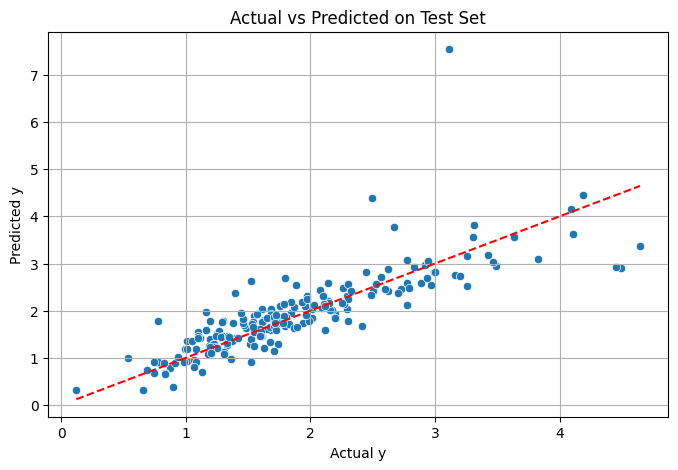

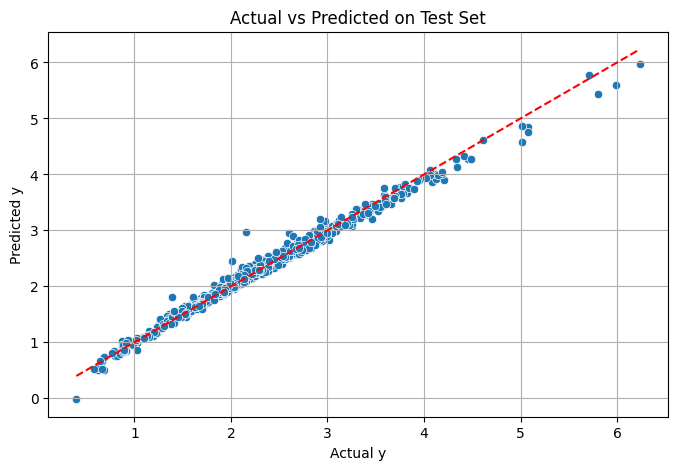

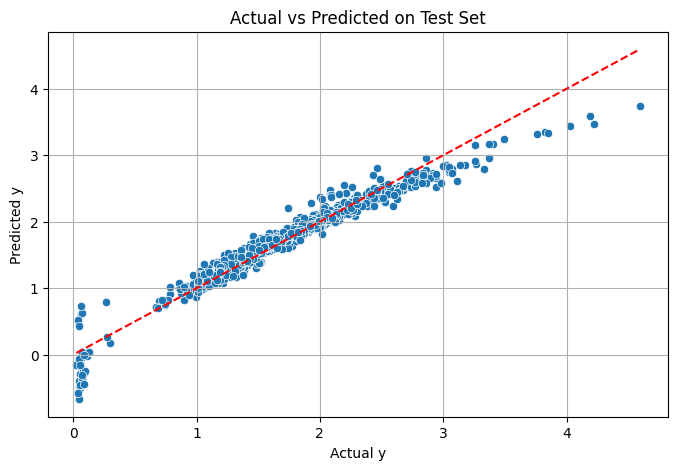

In [74]:
# === ĐẤT ===
result_visualization(y_dev_dat, y_pred_dat)
# === NHÀ ===
result_visualization(y_dev_nha, y_pred_nha)
# === CĂN HỘ ===
result_visualization(y_dev_ch, y_pre_ch)

In [80]:
def check_regression_assumptions(model, X, y):
    # Dự đoán
    y_pred = model.predict(X)
    residuals = y - y_pred

    # 1. Kiểm định Normality (Shapiro-Wilk)
    stat, p_value = shapiro(residuals)
    print(f"Shapiro-Wilk test for residual normality: stat={stat:.4f}, p={p_value:.4f}")
    if p_value > 0.05:
        print("=> Residuals appear normally distributed (fail to reject H0).")
    else:
        print("=> Residuals NOT normally distributed (reject H0).")
    # 2. Linearity check - plot residuals vs predicted
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values (Linearity check)')
    plt.show()
    print("=> Linearity: Residuals should be randomly scattered without pattern.")

    # 3. Independence check - Durbin-Watson
    dw_stat = durbin_watson(residuals)
    print(f"Durbin-Watson statistic: {dw_stat:.4f}")
    if 1.5 < dw_stat < 2.5:
        print("=> Residuals appear independent (no autocorrelation).")
    else:
        print("=> Residuals may have autocorrelation (violation of independence).")

Shapiro-Wilk test for residual normality: stat=0.6875, p=0.0000
=> Residuals NOT normally distributed (reject H0).


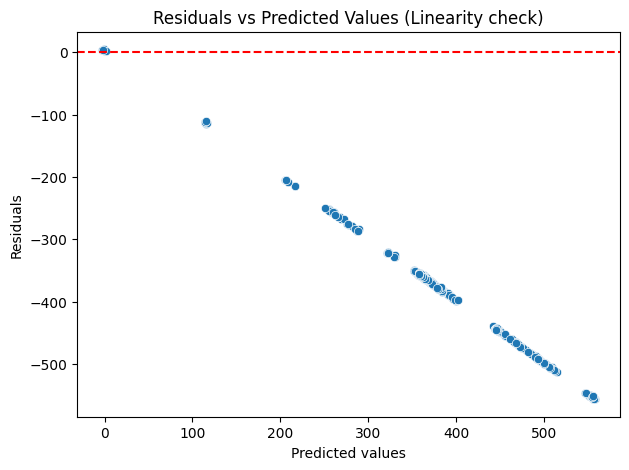

=> Linearity: Residuals should be randomly scattered without pattern.
Durbin-Watson statistic: 0.0721
=> Residuals may have autocorrelation (violation of independence).


In [82]:
check_regression_assumptions(model_dat, X_train_dat, y_train_dat)

Shapiro-Wilk test for residual normality: stat=0.9100, p=0.0000
=> Residuals NOT normally distributed (reject H0).


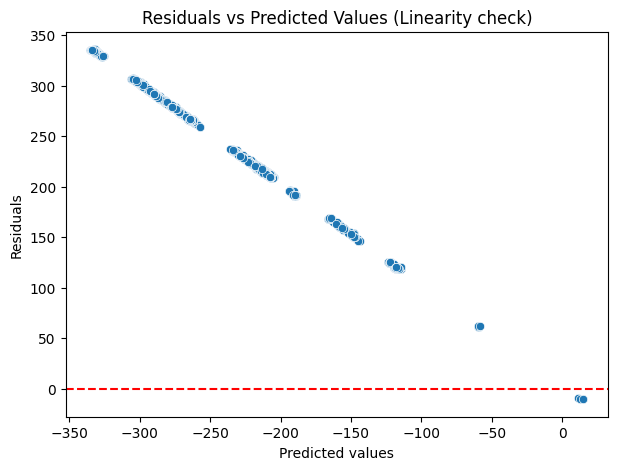

=> Linearity: Residuals should be randomly scattered without pattern.
Durbin-Watson statistic: 0.1742
=> Residuals may have autocorrelation (violation of independence).


In [83]:
check_regression_assumptions(model_nha, X_train_nha, y_train_nha)

c:\Users\Laptop-HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5325.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk test for residual normality: stat=0.4099, p=0.0000
=> Residuals NOT normally distributed (reject H0).


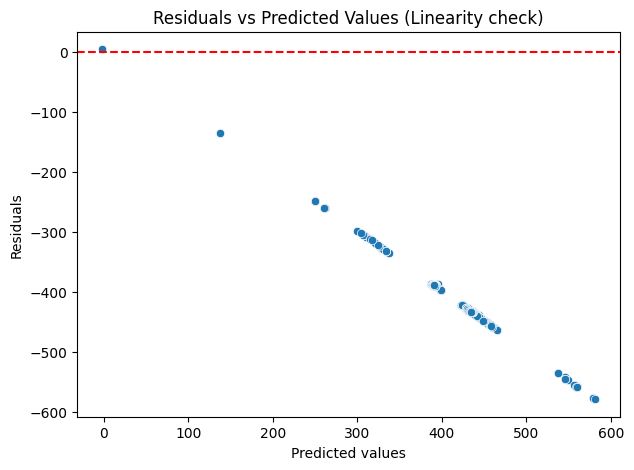

=> Linearity: Residuals should be randomly scattered without pattern.
Durbin-Watson statistic: 0.0059
=> Residuals may have autocorrelation (violation of independence).


In [84]:
check_regression_assumptions(model_ch, X_train_ch, y_train_ch)